# Working with Bootstrapped Threshold Data

A number of heat related climate indexes rely on thresholds (percentiles) caclulated as a centred 5-day window over the base period 1981 - 2010. As this only results in 145 data points we utilize a bootstrapping technique to increase the sample size. This is performed by randomly resampling the data, with replacement to create 200 unique samples. A number of percentiles are then calculated and averaged across the 200 samples. This results in a more robust representation of the true populations distribution. As this is a very computationally expensive process these thresholds have been pre-computed. The code utilised to calculate them can be accessed [here.](https://gist.github.com/peterm790/1f911a62e88b5578f468a495deb72b96)

In [1]:
import xarray as xr
import fsspec
import intake
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


At present only ERA5-Heat variables have finished processing. When ERA5 and ERA5-Land have finished the variables will be added to the intake catalogs, so that they can be accessed in the same manor as the other reanalysis data

In [2]:
fs = fsspec.filesystem("")
files = fs.ls('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/')
files

['/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRTmin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRT_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRTmax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCI_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc']

## Brief description of coordinates and variables:
### Coordinates:

- lat/lon: From the ECMWF reanalysis source data, but subselected to an africa only domain. [38N - 36S, 20E - 52W]
- dayofyear: The day of year from 0-365.
- quantile: The threshold calculated from the description above. Available quantiles are: [0.01, 0.02, 0.05, 0.1 , 0.25, 0.5 , 0.75, 0.9 , 0.95, 0.98, 0.99]


### Variables:
- bs_quantile_median: The median quantile value calculated from the bootstrapping technique. Unit is from the source data. Usually (K). The variable it corresponds to is at the start of the file name. 
- bs_quantile_variance: The variance of each quantile across the bootstrap ensembles. 

In [3]:
ds = xr.open_dataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')
ds

<xarray.Dataset>
Dimensions:               (lat: 297, lon: 289, quantile: 11, dayofyear: 365)
Coordinates:
  * lat                   (lat) float64 38.0 37.75 37.5 ... -35.5 -35.75 -36.0
  * lon                   (lon) float64 -20.0 -19.75 -19.5 ... 51.5 51.75 52.0
  * quantile              (quantile) float64 0.01 0.02 0.05 ... 0.95 0.98 0.99
  * dayofyear             (dayofyear) int64 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    bs_quantile_median    (dayofyear, quantile, lat, lon) float64 ...
    bs_quantile_variance  (dayofyear, quantile, lat, lon) float64 ...

In [4]:
ds['quantile'].values

array([0.01, 0.02, 0.05, 0.1 , 0.25, 0.5 , 0.75, 0.9 , 0.95, 0.98, 0.99])

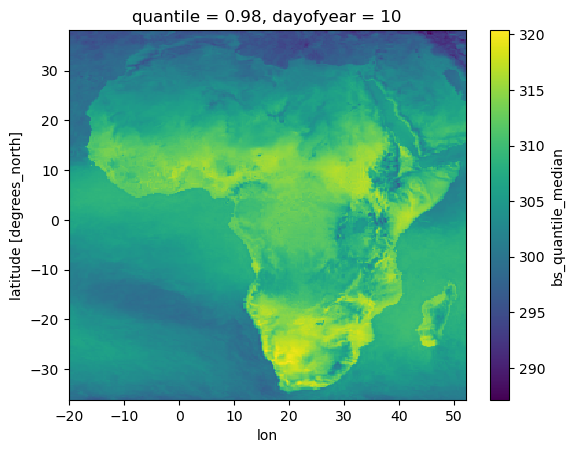

In [5]:
ds.bs_quantile_median.sel(quantile = 0.98, dayofyear = 10).plot()

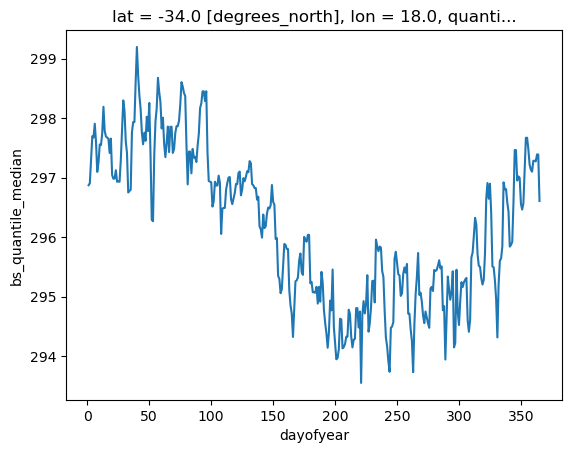

In [6]:
ds.bs_quantile_median.sel(quantile = 0.9, lat = -34, lon = 18).plot()

## Let's find out how many days exceed the 99th percentile over the previous 4 decades. 

In [7]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/climate/reanalysis/intake/reanalysis.yaml'))
ds_heat = catalog['ERA5-HEAT']['day']['UTCImax'].to_dask()
ds_heat = ds_heat.sel(lat = list(ds.lat.values), lon = list(ds.lon.values)).UTCImax #subselect same africa only domain
ds_heat = ds_heat.convert_calendar('noleap') # remove leap year conundrum 

In [8]:
def return_no_days_exceeding(ds_heat_sel, perc):
    x = (ds_heat_sel.groupby('time.dayofyear') >= ds.sel(quantile = perc).bs_quantile_median) #where the threshold is exceeded
    return (x/x).sum(dim = 'time', skipna = True) #set all non NAN values to zero, all NANs remain NAN. 

In [9]:
#silence warning when dividing by 0 as I am using this as a masking technique. not great coding practice but effective... 
import warnings
warnings.filterwarnings('ignore')

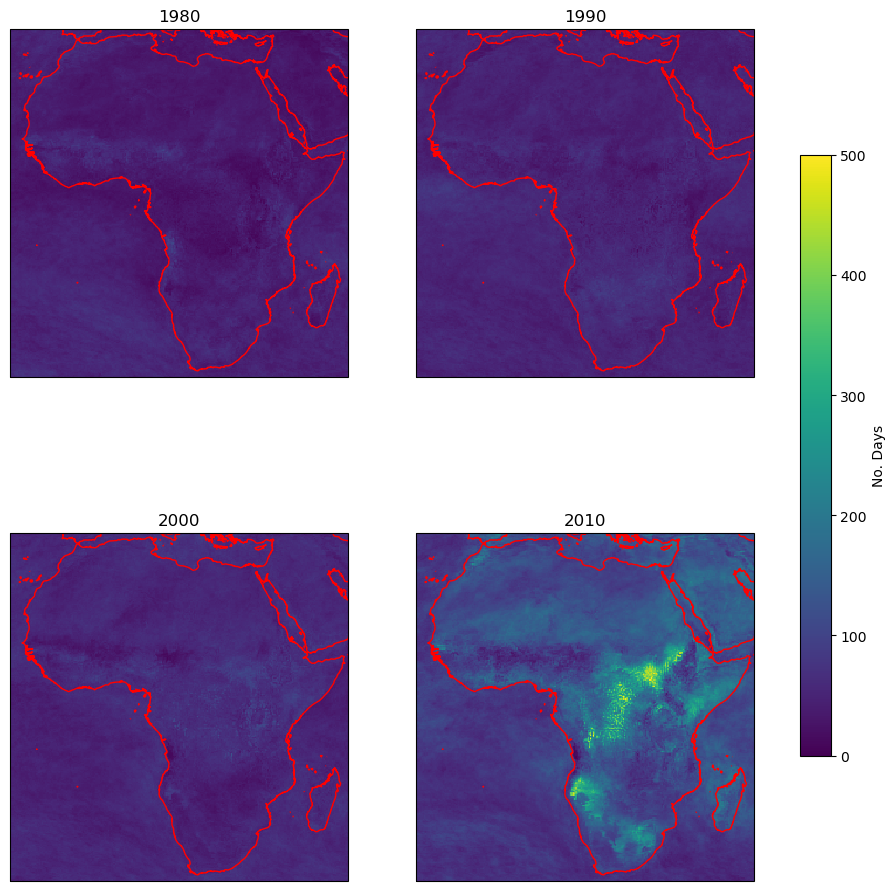

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,12),subplot_kw={'projection': ccrs.PlateCarree()})

for year,ax in zip([1980, 1990, 2000, 2010], axes.flatten()):
    ds_heat_sel = ds_heat.sel(time = slice(str(year), str(year+9)))
    ds_heat_sel = return_no_days_exceeding(ds_heat_sel, 0.99)
    p = ds_heat_sel.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), ax = ax, vmin = 0, vmax = 500, add_colorbar=False)
    ax.coastlines('10m', color='r')
    ax.title.set_text(str(year))
    
fig.colorbar(p, ax=axes.ravel().tolist(), label = 'No. Days', shrink = 0.65)